# 1. Đọc bộ dữ liệu

In [2]:
import pandas as pd
df = pd.read_csv('./IMDB-Dataset.csv')

# Xoá dòng dữ liệu trùng lặp
df = df.drop_duplicates()

In [3]:
# Làm sạch dữ liệu
import re
import string
import nltk
from bs4 import BeautifulSoup
import contractions

# Tải các tài nguyên từ nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Sử dụng bộ stopwords của NLTK
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Thiết lập danh sách các stopwords tiếng Anh
stop = set(stopwords.words('english'))

# Mở rộng từ viết tắt
def expand_contractions(text):
    return contractions.fix(text)

# Hàm tiền xử lý văn bản
def preprocess_text(text):
    wl = WordNetLemmatizer()

    # Loại bỏ các thẻ HTML
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()

    # Mở rộng từ viết tắt
    text = expand_contractions(text)

    # Loại bỏ biểu tượng cảm xúc
    emoji_clean = re.compile(
        "[" 
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'', text)

    # Thêm khoảng trắng sau dấu chấm nếu chưa có
    text = re.sub(r'\.(?=\S)', '. ', text)

    # Loại bỏ các URL
    text = re.sub(r'http\S+', '', text)

    # Loại bỏ dấu câu và chuyển văn bản thành chữ thường
    text = "".join([char.lower() for char in text if char not in string.punctuation])

    # Lemmatize từ và loại bỏ các stopwords, chỉ giữ lại các từ là chữ cái
    text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()])

    return text

# Áp dụng hàm tiền xử lý cho cột 'review' trong DataFrame
df['review'] = df['review'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to C:\Users\Phuong
[nltk_data]     Thu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Phuong
[nltk_data]     Thu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\Phuong Thu\AppData\Local\Temp\ipykernel_17148\3859848409.py:28: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


# 2. Phân tích dữ liệu

## 2.1. Phân tích phân bổ Nhãn dữ liệu trên bộ dữ liệu

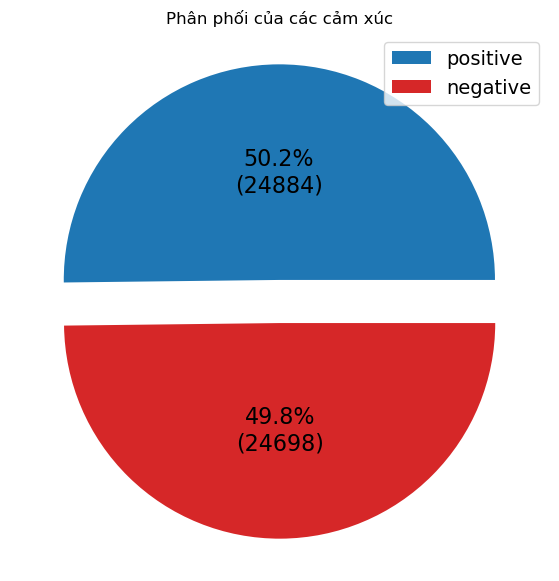

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Hàm tính toán giá trị tuyệt đối cho phần trăm và hiển thị trên biểu đồ
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Tính tần suất của các nhãn cảm xúc
freq_pos = len(df[df['sentiment'] == 'positive'])  # Số lượng cảm xúc tích cực
freq_neg = len(df[df['sentiment'] == 'negative'])  # Số lượng cảm xúc tiêu cực

data = [freq_pos, freq_neg]  # Dữ liệu tần suất cảm xúc
labels = ['positive', 'negative']  # Nhãn cho các phần của biểu đồ tròn

# Tạo biểu đồ tròn
plt.figure(figsize=[11,7])  # Thiết lập kích thước biểu đồ
plt.pie(
    x=data,
    autopct=lambda pct: func(pct, data),  # Hiển thị phần trăm và giá trị tuyệt đối
    explode=[0.1]*2,  # Tạo khoảng cách nhỏ giữa các phần của biểu đồ
    pctdistance=0.5,  # Khoảng cách từ trung tâm đến số phần trăm
    colors=[sns.color_palette()[0], 'tab:red'],  # Màu sắc của các phần (sử dụng bảng màu của seaborn)
    textprops={'fontsize': 16}  # Kích thước chữ
)

# Thiết lập chú thích
plt.legend(labels, loc="best", prop={'size': 14})  # Vị trí và kích thước chữ của chú thích
plt.title("Phân phối của các cảm xúc")  # Tiêu đề cho biểu đồ
plt.savefig("PieChart.png")  # Lưu biểu đồ thành file PNG
plt.show()  # Hiển thị biểu đồ


## 2.2 Phân tích sự Phân bổ Nhãn dữ liệu theo IF-IDF

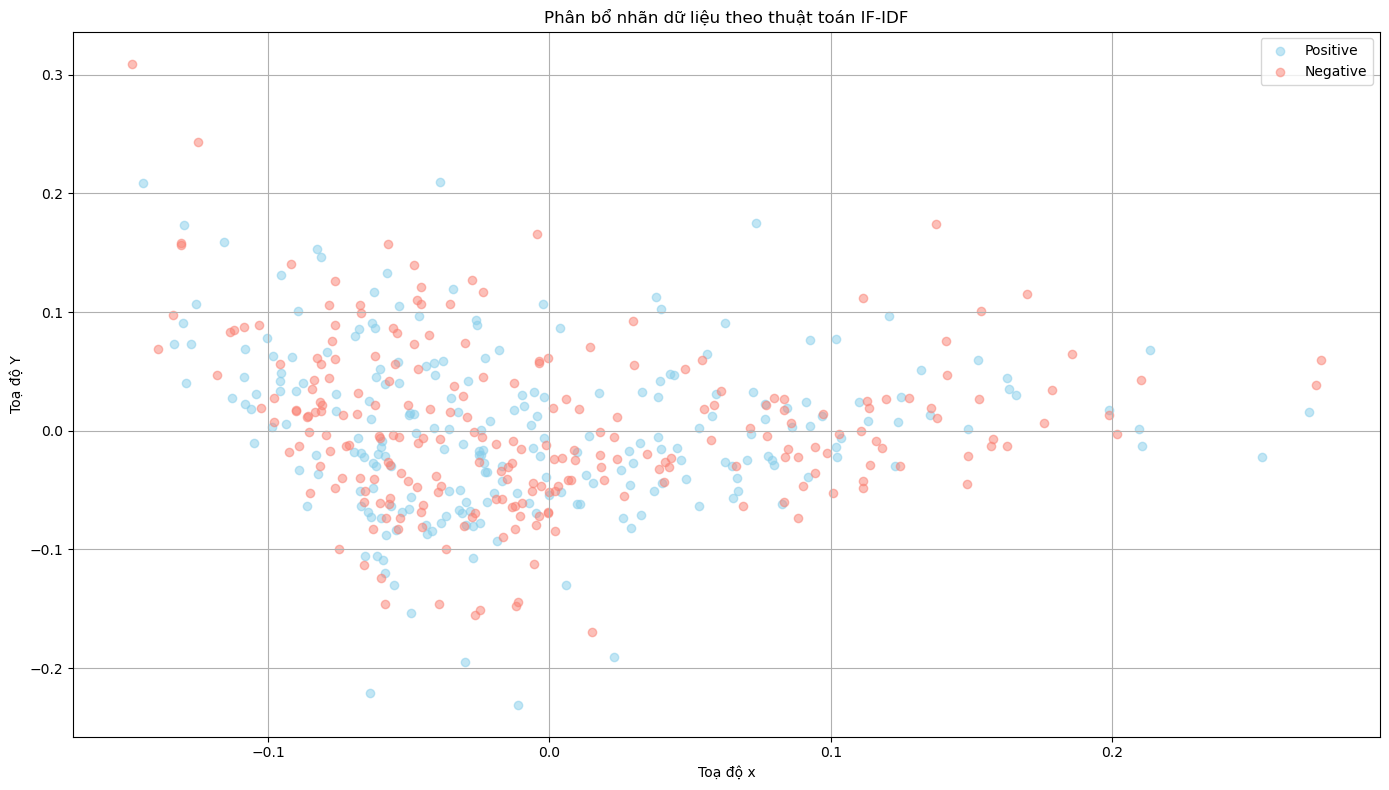

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
df_sample = df.sample(frac=0.1, random_state=42)  # Lấy mẫu 10% dữ liệu

# Khởi tạo TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=10000, min_df=5)  # Giới hạn số từ và loại bỏ từ hiếm
tfidf_matrix = tfidf.fit_transform(df_sample['review'])

# 2. Giảm chiều dữ liệu bằng PCA
pca = PCA(n_components=2)  # Giảm xuống 2 chiều
pca_result = pca.fit_transform(tfidf_matrix.toarray())

# 3. Tạo DataFrame cho kết quả PCA
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['sentiment'] = df_sample['sentiment']  # Thêm nhãn cảm xúc vào DataFrame

# 4. Vẽ biểu đồ scatter
plt.figure(figsize=(14, 8))
colors = {'positive': 'skyblue', 'negative': 'salmon'}
plt.scatter(pca_df[pca_df['sentiment'] == 'positive']['PCA1'],
            pca_df[pca_df['sentiment'] == 'positive']['PCA2'],
            color=colors['positive'], alpha=0.5, label='Positive')

plt.scatter(pca_df[pca_df['sentiment'] == 'negative']['PCA1'],
            pca_df[pca_df['sentiment'] == 'negative']['PCA2'],
            color=colors['negative'], alpha=0.5, label='Negative')

# Cấu hình biểu đồ
plt.title("Phân bổ nhãn dữ liệu theo thuật toán IF-IDF")
plt.xlabel("Toạ độ x")
plt.ylabel("Toạ độ Y")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## 2.3. Biểu đồ phân phối độ dài từ trong các đánh giá

### 2.3.1. Phương pháp IF-IDF phân tích các từ quan trọng trong các đánh giá

<Figure size 1400x800 with 0 Axes>

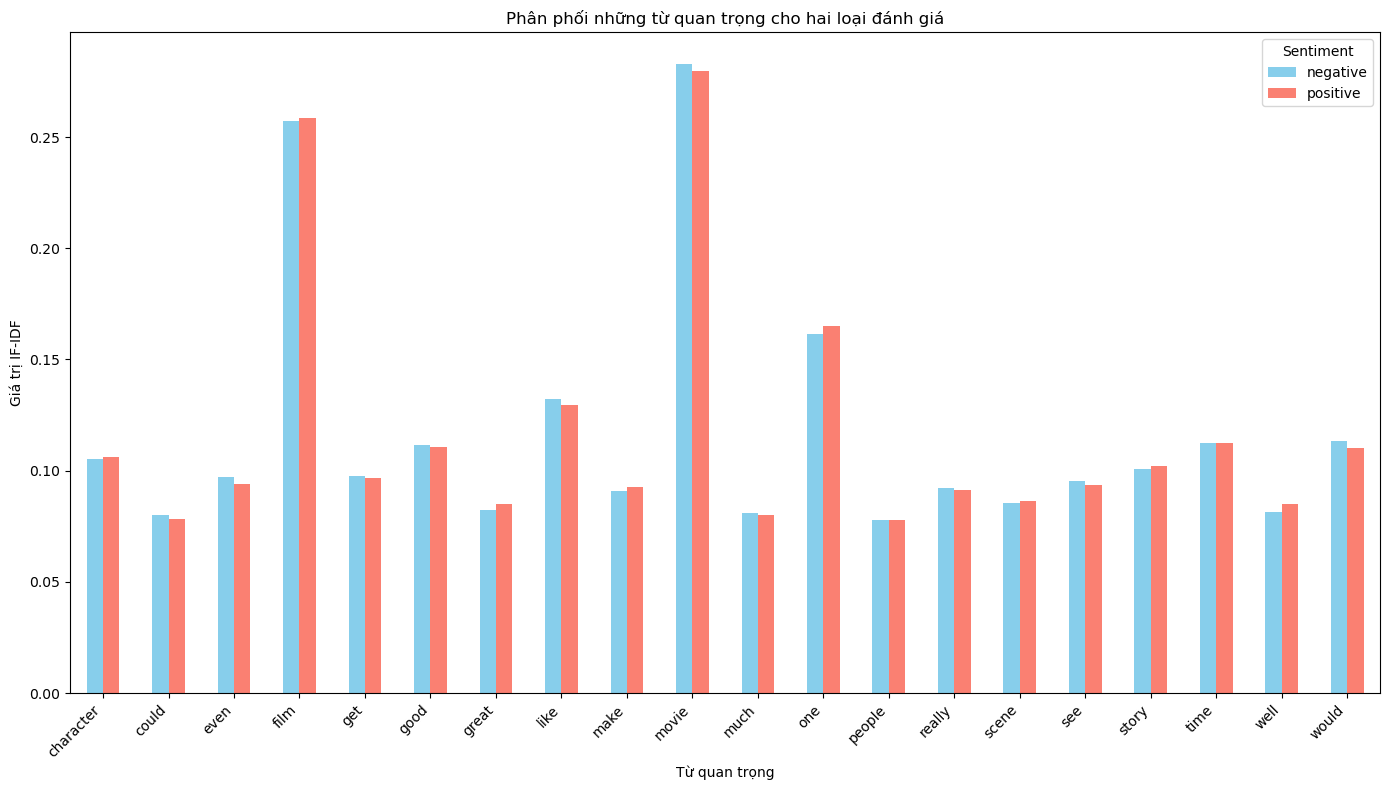

In [11]:
#Phân tích TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Tạo TF-IDF Vectorizer và áp dụng trên cột 'review'
tfidf = TfidfVectorizer(max_features=20)  # chỉ lấy 20 từ quan trọng nhất
tfidf_matrix = tfidf.fit_transform(df['review'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# Thêm cột sentiment từ df vào tfidf_df
tfidf_df['sentiment'] = df['sentiment']

# Tính trung bình điểm TF-IDF cho mỗi từ dựa trên cảm xúc
tfidf_means = tfidf_df.groupby('sentiment').mean()

# 4. Vẽ biểu đồ TF-IDF
plt.figure(figsize=(14, 8))
tfidf_means.T.plot(kind='bar', figsize=(14, 8), color=["skyblue", "salmon"])
plt.title("Phân phối những từ quan trọng cho hai loại đánh giá")
plt.xlabel("Từ quan trọng")
plt.ylabel("Giá trị IF-IDF")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Sentiment")
plt.tight_layout()
plt.savefig("tu_quan_trong.png")
plt.show()

### 2.3.2: Trong đánh giá tích cực

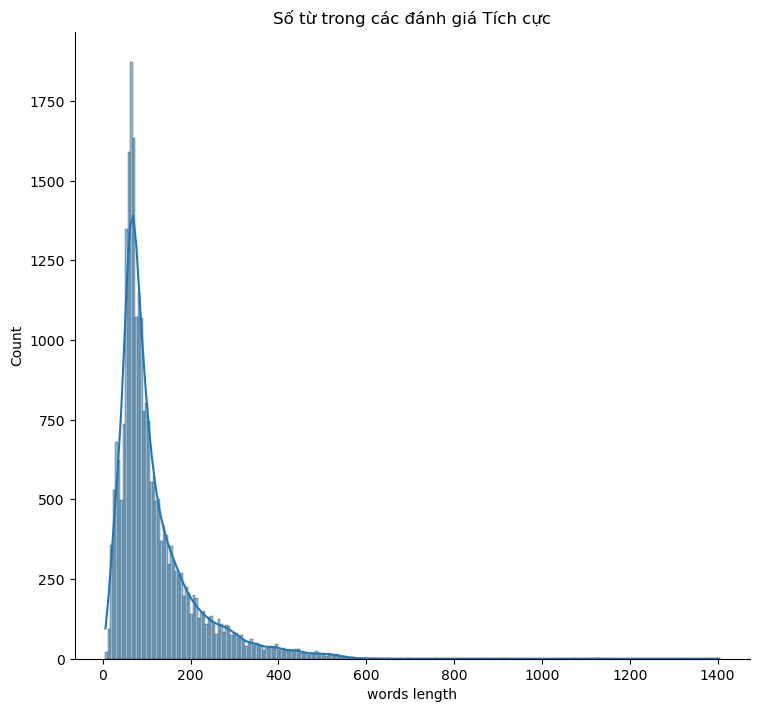

In [13]:
# Thống kê độ dài của các mẫu cho mỗi class
# Tính độ dài (số từ) của mỗi đánh giá trong cột 'review'
words_len = df['review'].str.split().map(lambda x: len(x))

# Thêm cột mới chứa độ dài của từng đánh giá
df['words length'] = words_len

# Biểu đồ phân phối độ dài từ trong các đánh giá tích cực
sns.displot(
    data=df[df['sentiment'] == 'positive'],  # Dữ liệu chỉ là đánh giá tích cực
    x="words length",  # Trục x là độ dài từ
    hue="sentiment",  # Phân biệt màu sắc theo cảm xúc
    kde=True,  # Hiển thị đường mật độ KDE (Kernel Density Estimate)
    height=7,  # Chiều cao của biểu đồ
    aspect=1.1,  # Tỉ lệ khung hình
    legend=False  # Không hiển thị chú thích tự động
).set(title='Số từ trong các đánh giá Tích cực')  # Đặt tiêu đề cho biểu đồ
plt.savefig('distribution_positive_reviews.png', format='png', dpi=300)
plt.show()  # Hiển thị biểu đồ


### 2.3.3: Trong đánh giá tích cực

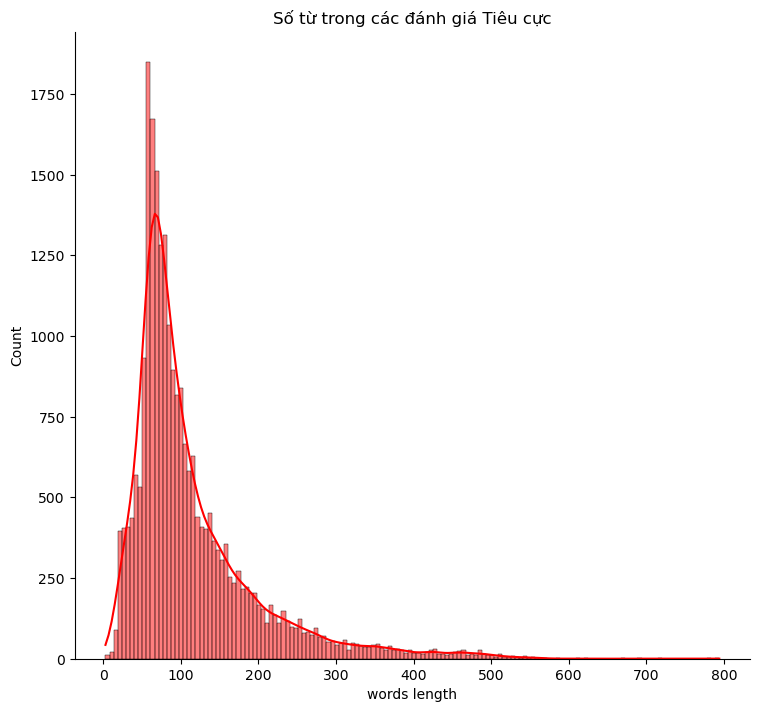

In [15]:
# Biểu đồ phân phối độ dài từ trong các đánh giá tiêu cực
sns.displot(
    data=df[df['sentiment'] == 'negative'],  # Dữ liệu chỉ là đánh giá tiêu cực
    x="words length",  # Trục x là độ dài từ
    hue="sentiment",  # Phân biệt màu sắc theo cảm xúc
    kde=True,  # Hiển thị đường mật độ KDE
    height=7,  # Chiều cao của biểu đồ
    aspect=1.1,  # Tỉ lệ khung hình
    legend=False,  # Không hiển thị chú thích tự động
    palette=['red']  # Sử dụng bảng màu đỏ cho đánh giá tiêu cực
).set(title='Số từ trong các đánh giá Tiêu cực')  # Đặt tiêu đề cho biểu đồ
plt.savefig('distribution_negative_reviews.png', format='png', dpi=300)
plt.show()  # Hiển thị biểu đồ

### 2.3.4: Trong cả 2 loại đánh giá

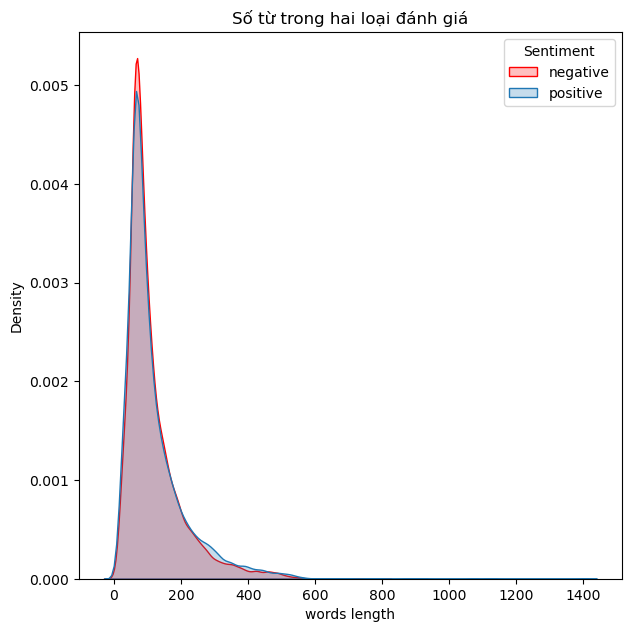

In [17]:
# Biểu đồ KDE cho cả hai loại đánh giá (tích cực và tiêu cực)
plt.figure(figsize=(7, 7.1))  # Thiết lập kích thước khung hình
sns.kdeplot(
    data=df,  # Sử dụng toàn bộ dữ liệu
    x="words length",  # Trục x là độ dài từ
    hue="sentiment",  # Phân biệt màu sắc theo cảm xúc
    fill=True,  # Tô màu bên dưới đường KDE
    palette=[sns.color_palette()[0], 'red']  # Màu sắc: mặc định cho tích cực, đỏ cho tiêu cực
).set(title='Số từ trong hai loại đánh giá')  # Đặt tiêu đề cho biểu đồ

# Thêm chú thích cho biểu đồ KDE
plt.legend(title='Sentiment', labels=['negative', 'positive'])
plt.savefig('distribution_both_review_types.png', format='png', dpi=300)
plt.show()  # Hiển thị biểu đồ KDE

# 3. Chia tập train và test

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

label_encode = LabelEncoder()
y_data = label_encode.fit_transform(df['sentiment'])

x_data = df['review']  # Đảm bảo x_data đã được định nghĩa

x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)

tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(x_train)

x_train_encoded = tfidf_vectorizer.transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)

# 4. Huấn luận và đánh giá mô hình

## 4.1. Dùng thư viện

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Huấn luyện mô hình
dt_classifier = DecisionTreeClassifier(criterion='entropy',random_state=42)
dt_classifier.fit(x_train_encoded, y_train)
y_pred_dt = dt_classifier.predict(x_test_encoded)

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(x_train_encoded, y_train)
y_pred_rf = rf_classifier.predict(x_test_encoded)

# Hàm kiểm tra kích thước và đánh giá hiệu suất của mô hình cho cả hai lớp
def evaluate_model(y_true, y_pred, model_name):
    if len(y_true) != len(y_pred):
        print(f"Size mismatch: y_true ({len(y_true)}) vs y_pred ({len(y_pred)}) for model {model_name}")
        return
    
    accuracy = accuracy_score(y_true, y_pred)
    
    # Tính cho từng lớp
    precision_pos = precision_score(y_true, y_pred, pos_label=1) * 100
    recall_pos = recall_score(y_true, y_pred, pos_label=1) * 100
    f1_pos = f1_score(y_true, y_pred, pos_label=1)
    
    precision_neg = precision_score(y_true, y_pred, pos_label=0) * 100
    recall_neg = recall_score(y_true, y_pred, pos_label=0) * 100
    f1_neg = f1_score(y_true, y_pred, pos_label=0)
    
    # Tính trung bình macro
    precision_macro = precision_score(y_true, y_pred, average='macro') * 100
    recall_macro = recall_score(y_true, y_pred, average='macro') * 100
    f1_macro = f1_score(y_true, y_pred, average='macro')

    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    
    print("Positive Class (1):")
    print(f"  Precision: {precision_pos:.3f}%")
    print(f"  Recall: {recall_pos:.3f}%")
    print(f"  F1 Score: {f1_pos:.3f}")
    
    print("Negative Class (0):")
    print(f"  Precision: {precision_neg:.3f}%")
    print(f"  Recall: {recall_neg:.3f}%")
    print(f"  F1 Score: {f1_neg:.3f}")
    
    print("Macro Average:")
    print(f"  Precision: {precision_macro:.3f}%")
    print(f"  Recall: {recall_macro:.3f}%")
    print(f"  F1 Score: {f1_macro:.3f}")
    print('-' * 30)

# Đánh giá hiệu suất của mô hình
evaluate_model(y_test, y_pred_dt, "Decision Tree Classifier")
evaluate_model(y_test, y_pred_rf, "Random Forest Classifier")

Model: Decision Tree Classifier
Accuracy: 71.81%
Positive Class (1):
  Precision: 71.647%
  Recall: 72.539%
  F1 Score: 0.721
Negative Class (0):
  Precision: 71.970%
  Recall: 71.067%
  F1 Score: 0.715
Macro Average:
  Precision: 71.809%
  Recall: 71.803%
  F1 Score: 0.718
------------------------------
Model: Random Forest Classifier
Accuracy: 84.21%
Positive Class (1):
  Precision: 84.619%
  Recall: 83.769%
  F1 Score: 0.842
Negative Class (0):
  Precision: 83.804%
  Recall: 84.653%
  F1 Score: 0.842
Macro Average:
  Precision: 84.211%
  Recall: 84.211%
  F1 Score: 0.842
------------------------------


# Xây dựng mô hình bằng cách cài đặt thuật toán thủ công  

In [24]:
import numpy as np
import pandas as pd
import re
import string
import contractions
import nltk
from math import log
from collections import Counter
from bs4 import BeautifulSoup
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import cross_val_score
# Ensure necessary NLTK resources are available
nltk.download('stopwords')
nltk.download('wordnet')

# Đọc dữ liệu đã làm sạch
df = pd.read_csv("./IMDB-Dataset.csv").head(100)

# Xoá dòng dữ liệu trùng lặp
df = df.drop_duplicates()

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
# Set of stopwords
stop = set(stopwords.words('english'))

# Expanding contractions function
def expand_contractions(text):
    return contractions.fix(text)

# Function to clean data
def preprocess_text(text):
    wl = WordNetLemmatizer()
    if isinstance(text, str) and ('<html>' in text or '<body>' in text):
        soup = BeautifulSoup(text, "html.parser")  # Removing HTML tags
        text = soup.get_text()
    text = expand_contractions(text)  # Expanding chatwords and contractions

    # Removing emojis
    emoji_clean = re.compile(
        "[" 
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
    )
    text = emoji_clean.sub(r'', text)
    text = re.sub(r'\.(?=\S)', '. ', text)  # Add space after full stop
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = "".join([word.lower() for word in text if word not in string.punctuation])  # Remove punctuation and make text lowercase
    text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()])  # Lemmatize

    return text

# Định nghĩa lớp ID3
class ID3:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.tree = None
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split

    def entropy(self, df) -> float:
        label_counts = df[df.columns[-1]].value_counts()
        return -sum((count / len(df)) * log(count / len(df), 2) for count in label_counts)

    def entropy_attribute(self, df, attribute: str) -> float:
        return sum(
            self.entropy(df[df[attribute] == value]) * len(df[df[attribute] == value]) / len(df)
            for value in df[attribute].unique()
        )

    def information_gain(self, df) -> str:
        gains = [
            self.entropy(df) - self.entropy_attribute(df, attribute) for attribute in df.columns[:-1]
        ]
        return df.columns[:-1][np.argmax(gains)]

    def subset(self, df, node, value):
        return df[df[node] == value].reset_index(drop=True)

    def build_tree(self, df, depth=0):
        # Kiểm tra nếu df rỗng
        if df.empty:
            return  # Hoặc giá trị mặc định
        node = self.information_gain(df)
        tree = {node: {}}
        unique_values = np.unique(df[node])

        for value in unique_values:
            subset_df = self.subset(df, node, value)
            label_counts = subset_df[df.columns[-1]].value_counts()
            # Kiểm tra xem label_counts có rỗng không
            if label_counts.empty:
                tree[node][value] = None  
            if len(label_counts) == 1:
                tree[node][value] = label_counts.idxmax()
            elif (self.max_depth is not None and depth >= self.max_depth) or len(subset_df) < self.min_samples_split:
                tree[node][value] = label_counts.idxmax()
            else:
                tree[node][value] = self.build_tree(subset_df, depth + 1)
        return tree

    def fit(self, df):
        if df.empty:
            return
        self.tree = self.build_tree(df.astype('object'))

    def predict(self, df):
        return np.array([self._predict(self.tree, sample) for _, sample in df.iterrows()])

    def _predict(self, tree, sample) -> str:
        if not isinstance(tree, dict):
            return tree
        root_node = next(iter(tree))
        feature_value = sample[root_node]
        if feature_value in tree[root_node]:
            return self._predict(tree[root_node][feature_value], sample)
        return list(tree[root_node].values())[0]  # Giá trị mặc định
    #Sử dụng cho tìm kiếm các tham số đặc trưng Cross
    def score(self, X, y):
        predictions = self.predict(X)
        return accuracy_score(y, predictions)

# Định nghĩa lớp RandomForest
class RandomForest:
    def __init__(self, n_trees=10, max_depth=None, min_samples_split=2, max_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.forest = []

    def random_features(self, df):
        total_features = df.columns[:-1]
        if self.max_features == 'sqrt':
            num_features = int(np.sqrt(len(total_features)))  # Sử dụng căn bậc hai
        else:
            num_features = min(self.max_features or len(total_features), len(total_features))
        return np.random.choice(total_features, size=num_features, replace=False)

    def bootstrap_sample(self, df):
        indices = np.random.randint(0, len(df), len(df))
        return df.iloc[indices]

    def fit(self, X,y):
        df = pd.DataFrame(X)  # Đảm bảo X là DataFrame
        # df['sentiment'] = y.reset_index(drop=True)
        df['sentiment'] = pd.Series(y).reset_index(drop=True)  # Chuyển y thành Series
        # Kiểm tra nếu df không rỗng
        if df.empty:
            return
        # df là DataFrame
        if isinstance(df, np.ndarray):
            df = pd.DataFrame(df)
        for _ in range(self.n_trees):
            sample_df = self.bootstrap_sample(df)
            selected_features = np.concatenate((self.random_features(sample_df), [df.columns[-1]]))
            sample_df = sample_df[selected_features]
            # Kiểm tra nếu sample_df không rỗng
            if sample_df.empty:
                continue  # Bỏ qua cây này nếu không có dữ liệu
            tree = ID3(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(sample_df)
            self.forest.append(tree)

    def predict(self, df):
        tree_predictions = np.array([tree.predict(df) for tree in self.forest])
        return np.array([Counter(tree_predictions[:, i]).most_common(1)[0][0] for i in range(len(df))])
    #Sử dụng cho tìm kiếm các tham số đặc trưng GridSearchCV
    def score(self, X, y):
        predictions = self.predict(X)
        return accuracy_score(y, predictions)
    
    def get_params(self,deep=True):
        return {
            'n_trees': self.n_trees,
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split,
            'max_features': self.max_features
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self


# Apply preprocessing to reviews
df['review'] = df['review'].apply(preprocess_text)
# Mã hóa nhãn cảm xúc (tích cực/tiêu cực) thành số
label_encode = LabelEncoder()
df['sentiment'] = label_encode.fit_transform(df['sentiment'])

# Phân chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=42)

# Sử dụng TfidfVectorizer để chuyển đổi văn bản thành ma trận đặc trưng
vectorizer = TfidfVectorizer(max_features=15000,ngram_range=(1, 2))  # Giới hạn số lượng từ
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Áp dụng TruncatedSVD để giảm chiều dữ liệu
n_components=50
svd = TruncatedSVD(n_components=n_components)  # Giảm số lượng thành phần
X_train_reduced = svd.fit_transform(X_train_vectorized)
X_test_reduced = svd.transform(X_test_vectorized)


#K-Fold
from sklearn.model_selection import KFold

# Số lần gấp (folds)
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Hàm để thực hiện cross-validation cho ID3
def cross_val_id3(X, y):
    accuracies = []
    for train_index, val_index in kf.split(X):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]
        
        id3_model = ID3(max_depth=5, min_samples_split=2)
        id3_model.fit(pd.DataFrame(X_train_fold, columns=[f'PC{i}' for i in range(n_components)]).assign(sentiment=y_train_fold))
        
        y_pred = id3_model.predict(pd.DataFrame(X_val_fold, columns=[f'PC{i}' for i in range(n_components)]))
        accuracies.append(accuracy_score(y_val_fold, y_pred))
    
    return np.mean(accuracies)

# Hàm để thực hiện cross-validation cho Random Forest
def cross_val_random_forest(X, y):
    accuracies = []
    for train_index, val_index in kf.split(X):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]
        
        rf_model = RandomForest(n_trees=20, max_depth=5, min_samples_split=2, max_features='sqrt')
        rf_model.fit(pd.DataFrame(X_train_fold, columns=[f'PC{i}' for i in range(n_components)]), y_train_fold)

        
        y_pred = rf_model.predict(pd.DataFrame(X_val_fold, columns=[f'PC{i}' for i in range(n_components)]))
        accuracies.append(accuracy_score(y_val_fold, y_pred))
    
    return np.mean(accuracies)

# Áp dụng cross-validation
average_id3_accuracy = cross_val_id3(X_train_reduced, y_train.values)
average_rf_accuracy = cross_val_random_forest(X_train_reduced, y_train.values)

# In ra kết quả
print(f"Average accuracy of ID3 classifier: {average_id3_accuracy:.2f}")
print(f"Average accuracy of Random Forest classifier: {average_rf_accuracy:.2f}")


[nltk_data] Downloading package stopwords to C:\Users\Phuong
[nltk_data]     Thu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Phuong
[nltk_data]     Thu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Phuong
[nltk_data]     Thu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Phuong
[nltk_data]     Thu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Average accuracy of ID3 classifier: 0.65
Average accuracy of Random Forest classifier: 0.65


# 5. Dự đoán nhãn cho dữ liệu nhập vào

In [39]:
# Hàm dự đoán cảm xúc
def predict_sentiment(text, classifier,vectorizer):
    # Tiền xử lý văn bản đầu vào
    processed_text = preprocess_text(text)
    
    # Biến đổi văn bản thành đặc trưng TF-IDF với vectorizer
    text_vector = vectorizer.transform([processed_text])
    
    # Dự đoán nhãn cho văn bản
    prediction = classifier.predict(text_vector)
    sentiment = label_encode.inverse_transform(prediction)

    return sentiment[0]

# Nhập văn bản và đưa ra dự đoán
input_text = input("Please enter a review: ")
predicted_sentiment = predict_sentiment(input_text, rf_classifier,tfidf_vectorizer)
print(f"Sentiment predict is: {predicted_sentiment}")

Please enter a review:  so bad


Sentiment predict is: negative
